## Projeto 2 - Implementação Self-Organizing Maps (SOM)



PROJECT 2 - SOM
- Realizar experimentos com pelo menos 3 datasets (usar o Iris para debug). Variar a vizinhança e taxa de aprendizagem
- Apresentar, pelo menos, os seguintes mapas:
    - U-Matrix
    - Hit map e Heat maps
    - Erro de quantização e topográfico
- Entregar relatório descrevendo os experimentos

## Exemplo 01 Dataset: IRIS

In [1]:
from sklearn import datasets

## Bibliotecas

In [2]:
import sys
sys.path.insert(0, '../')

from minisom import MiniSom

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

%load_ext autoreload

In [3]:
# carregar dados
iris = datasets.load_iris()
data = iris.data
# data normalization
data = np.apply_along_axis(lambda x: x/np.linalg.norm(x), 1, data)

In [4]:
classes = iris.target_names
features = iris.feature_names
iris_target = iris.target

df_iris = pd.DataFrame(data, columns=features)
df_iris["class_id"] = iris_target
df_iris["class"] = 0

# Creating numeric class identifiers (0,1,2) 
df_iris.loc[df_iris["class_id"]==0, 'class'] = str(classes[0])
df_iris.loc[df_iris["class_id"]==1, 'class'] = str(classes[1])
df_iris.loc[df_iris["class_id"]==2, 'class'] = str(classes[2])

In [5]:
df_iris

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class_id,class
0,0.803773,0.551609,0.220644,0.031521,0,setosa
1,0.828133,0.507020,0.236609,0.033801,0,setosa
2,0.805333,0.548312,0.222752,0.034269,0,setosa
3,0.800030,0.539151,0.260879,0.034784,0,setosa
4,0.790965,0.569495,0.221470,0.031639,0,setosa
...,...,...,...,...,...,...
145,0.721557,0.323085,0.560015,0.247699,2,virginica
146,0.729654,0.289545,0.579090,0.220054,2,virginica
147,0.716539,0.330710,0.573231,0.220474,2,virginica
148,0.674671,0.369981,0.587616,0.250281,2,virginica


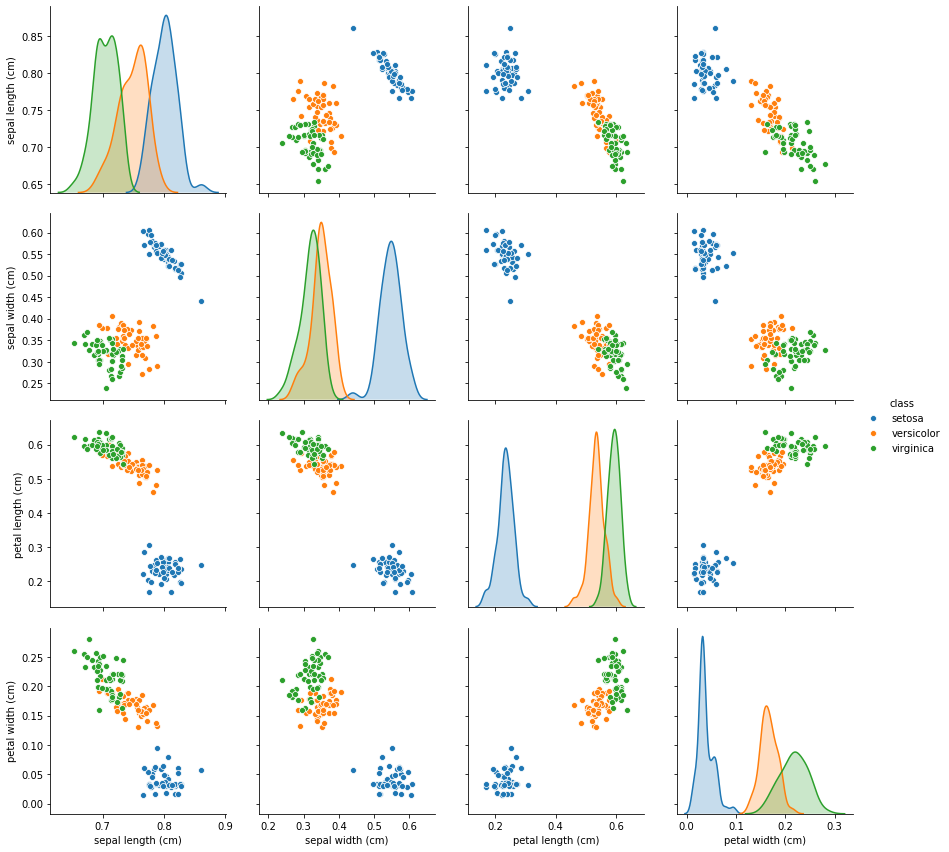

In [6]:
sns.pairplot(df_iris.drop("class_id", axis=1), hue="class", height=3, diag_kind="kde")

#### Inicializando modelo

#### Treinamento

Para inicialização de um objeto da biblioteca Minisom é necessário atribuír os parametros uma variável.


O primeiro parametro está relacionado as dimenssões do dataset, no caso do exemplo Iris as dimenssões são **(x = 7, y=7)** o que significa que ao final teremos 7 * 7 valores de saída, por tanto, quanto maior o mapa auto-organizado maior o tempo de treinamento.

O segundo parametro **input_len** é o número de caracteristicas (features, caso do exemplo da iris coorresponde aos sepal length (cm), sepal width (cm), petal length (cm),petal width (cm)]) neste caso o valor de entrada é igual a 4.

O parametro **sigma** corresponde ao raio dos diferentes vizinhos no som, o padrão é 1.0.

O parametro **learning_rate** determina a taxa de ajuste dos pesos durante cada iteração.

O ultimo parametro é a função de pesos da vizinhança **neighborhood** de uma posição no mapa valores possíveis: 'gaussian', 'mexican_hat', 'bubble' ou 'triangle'

In [53]:
# Inicialização e treinamento
som = MiniSom(x= 7, y = 7, input_len = 4, sigma=3, learning_rate=0.5,
             neighborhood_function='triangle', random_seed=10)

The next step is to initialize the SOM’s weights to small, standardized random values. We achieve this using the random_weights_init function and by passing in our data (the pixels).

In [54]:
som.pca_weights_init(data)
print("Training...")
som.train_batch(data, 1000, verbose=True)  # random training
print("\n...ready!")

Training...


 [ 1000 / 1000 ] 100% - 0:00:00 left 
 quantization error: 0.015586368299659998
 topographic error: 0.88

...ready!


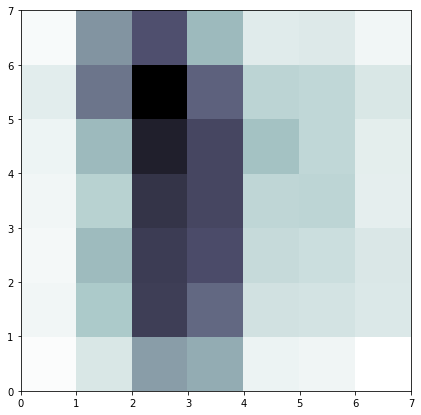

In [55]:
plt.figure(figsize=(7, 7))
# Plotting the response for each pattern in the iris dataset
plt.pcolor(som.distance_map().T, cmap='bone_r')  

iteration=9999 status=100.00% error=0.013511796335732781

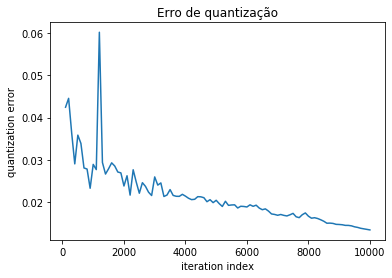

In [56]:
som = MiniSom(7, 7, 4, sigma=3, learning_rate=0.5, 
              neighborhood_function='triangle', random_seed=10)

som.pca_weights_init(data)
max_iter = 10000
q_error_pca_init = []
iter_x = []
for i in range(max_iter):
    percent = 100*(i+1)/max_iter
    rand_i = np.random.randint(len(data)) # Corresponde ao treinamento randomico
    som.update(data[rand_i], som.winner(data[rand_i]), i, max_iter)
    if (i+1) % 100 == 0:
        error = som.quantization_error(data)
        q_error_pca_init.append(error)
        iter_x.append(i)
        sys.stdout.write(f'\riteration={i:2d} status={percent:0.2f}% error={error}')

plt.title('Erro de quantização')
plt.plot(iter_x, q_error_pca_init)
plt.ylabel('quantization error')
plt.xlabel('iteration index')
plt.show()

In [57]:
class_assignments = som.labels_map(data, df_iris['class'])

def classify(som, data, class_assignments):
    """Classifies each sample in data in one of the classes definited
    using the method labels_map.
    Returns a list of the same length of data where the i-th element
    is the class assigned to data[i].
    """
    winmap = class_assignments
    default_class = np.sum(list(winmap.values())).most_common()[0][0]
    result = []
    for d in data:
        win_position = som.winner(d)
        if win_position in winmap:
            result.append(winmap[win_position].most_common()[0][0])
        else:
            result.append(default_class)
    return result

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, df_iris['class'])

som.pca_weights_init(X_train)
som.train_random(X_train, 5000, verbose=False)
class_assignments = som.labels_map(X_train, y_train)

print(classification_report(y_test, classify(som, X_test, class_assignments)))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        13
  versicolor       1.00      0.93      0.97        15
   virginica       0.91      1.00      0.95        10

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



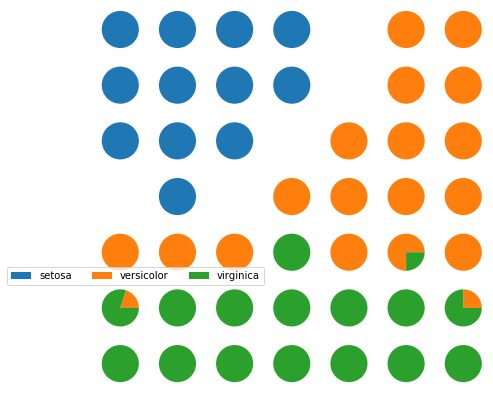

In [64]:
labels_map = som.labels_map(data, df_iris['class'])
label_names = np.unique(df_iris['class'])

plt.figure(figsize=(7, 7))
the_grid = GridSpec(7, 7)
for position in labels_map.keys():
    label_fracs = [labels_map[position][l] for l in label_names]
    plt.subplot(the_grid[6-position[1], position[0]], aspect=1)
    patches, texts = plt.pie(label_fracs)
plt.legend(patches, label_names, bbox_to_anchor=(0, 1.5), ncol=3)
plt.show()

## Exemplo 02: California Housing

In [75]:
from sompy.sompy import SOMFactory
# from sklearn.datasets import fetch_california_housing

ModuleNotFoundError: No module named 'sompy'